In [1]:
import torch
from d2l import torch as d2l

# 循环神经网络
对于 $n$源语法模型, 其中单词$x_t$在时间步$t$的条件概率仅取决于前面$n-1$个单词, 对于时间步$t-(n-1)$之间的单词, 如果我们想要将其产生的影响合并到 $x_t$ 上, 需要增加 $n$, 然而模型参数的数量也会随之增长, 词表$\mathcal{V}$中需要存储$|\mathcal{V}|^n$个数字, 因此可以使用隐变量来构造模型(也就是利用一个隐变量来总结之前的观测值):
$$
P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),
$$
其中$h_{t-1}$是隐状态, 也叫做隐藏变量, 村出了时间步$t-1$的序列信息, 通常可以基于当前输入$x_t$和先前隐状态$h_{t-1}$来计算时间步$t$处的任何时间的隐状态:
$$
h_t = f(x_t, h_{t-1})
$$

注意区分**隐藏层**和**隐状态**两者的不同, 前者是输入到输出路径上隐藏的层(从观测的角度来看, `MLP`模型的中间层), 隐状态是在给定步骤所作所有事情的输入, 并且这些状态智能通过先前时间步的数据来计算

**循环神经网络(RNN):** 是具有隐状态的神经网络

## 无隐状态的神经网络
对于只有单隐藏层的多层感知机, 设隐藏层的激活函数为$\phi$, 给定一个小批量数据 $\mathbf{X} \in \mathbb{R}^{n \times d}$, 批量大小为 $n$, 输入维度为 $d$, 当隐藏层的输出 $\mathbf{H} \in \mathbb{R}^{n \times h}$通过下式计算:
$$
\mathbf{H} = \phi(\mathbf{X}\mathbf{W}_{xh} + \mathbf{b}_h)
$$
其中隐藏层权重 $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$, 偏置参数为 $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$以及隐藏单元的数量为 $h$, 使用广播机制进行球和, 同时隐藏变量 $\mathbf{H}$ 用于输出层的输入, 输出为:
$$
\mathbf{O} = \mathbf{H}\mathbf{W}_{hq} + \mathbf{b}_q
$$
其中 $\mathbf{O} \in \mathbb{R}^{n \times q}$是输出变量, $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$, $\mathbf{q}_q \in \mathbb{R}^{1 \times q}$是输出层的偏执参数, 如果是分类问题可以使用 $softmax(\mathbf{O})$来计算输出类别的概率分布(其实是损失函数中使用交叉熵函数)

## 有隐状态的循环神经网络
假设时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$, 同时对于 $n$ 个序列样本的小批量, $\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本, 同时使用 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$表示时间步$t$的隐藏变量, 此时我们还需要保存一个前面一个时间步的隐藏变量 $\mathbf{H}_{t-1}$, 并且引入一个新的权重参数 $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$用于描述如何在当前时间补中使用前一个时间步的隐藏变量:
$$
\mathbf{H}_t = \phi(\mathbf{X}_t\mathbf{W}_{xh} + \mathbf{H}_{t-1}\mathbf{W}_{hh} + \mathbf{b}_h)
$$
对于 $\mathbf{H}_t$这些隐藏变量, 捕获并且保留了序列直到其当前时间步的历史信息, 这些状态称为隐状态, 并且在当前时间步中, 隐状态计使用的定义和前面一个时间步中使用的定义相同, 因此上式的计算是循环的, 所以基于循环计算的隐状态神经网络称为循环神经网络, 在循环神经网络中计算的层叫做循化层

同时循环神经网络的输出为, 对于时间步$t$:
$$
\mathbf{O}_t = \mathbf{H}_t \mathbf{H}_{hq} + \mathbf{b}_q
$$
同时在不同的时间步, `RNN`也是使用这些模型参数(前提是序列的规律是不变的), 因此, 循环神经网络的参数开销不会随着时间步的增加而增加

循环神经网络的计算过程如下, 注意每一层的输入以及每一层的 $\mathbf{H}_t$会被送入到全连接输出层, 用于计算当前时间步的输出 $\mathbf{O}_t$, 也就是每一个时间点都对应着输出和输出:
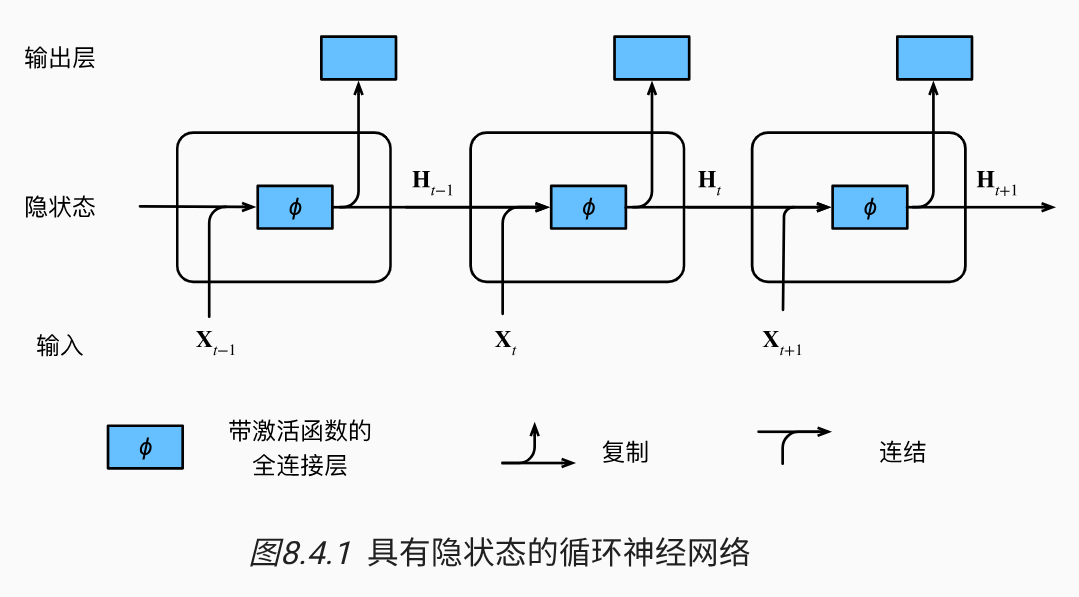

同时注意 $\mathbf{X}_t\mathbf{W}_{xh} + \mathbf{H}_{t-1}\mathbf{W}_{hh}$, 其实相当于 $\mathbf{X_t}, \mathbf{H}_{t-1}$沿着列方向拼接, 同时 $\mathbf{W}_{xh},\mathbf{W}_{hh}$沿着行方向拼接, 之后进行矩阵乘法就可以得到

In [2]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.6414, -0.6002, -0.9503,  2.2688],
        [-1.4181,  0.6978,  0.5779, -2.9253],
        [-2.2912,  0.4485, -1.5936,  0.7204]])

In [5]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.6414, -0.6002, -0.9503,  2.2688],
        [-1.4181,  0.6978,  0.5779, -2.9253],
        [-2.2912,  0.4485, -1.5936,  0.7204]])

## 基于RNN的字符级语言模型
假设目标是根据过去和当前词元预测下一个词元, 那么可以把原始的序列移位一个词元作为标签, 同时原始序列作为输入, 那么此时的网络结构如下:
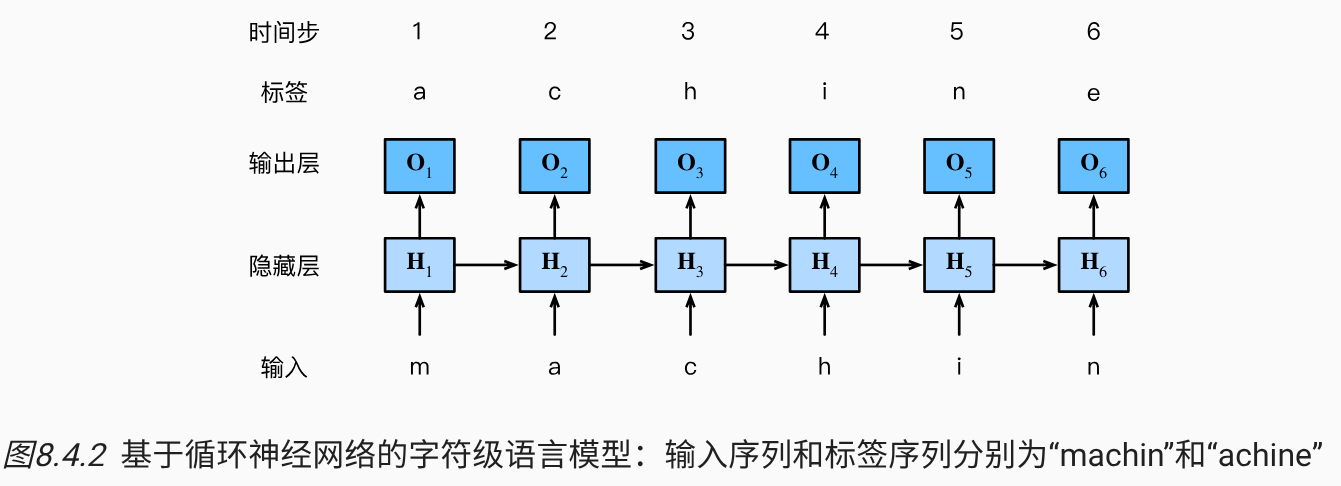
同时可以使用 softmax 操作对于每一个时间补的输入进行操作, 之后利用交叉熵损失计算模型输出和标签之间的误差
可以发现 `RNN` 和 `MLP, CNN`的不同之处在与每一个时间步长都有相应的输出, 同时时间步 $t$ 输入的 $\mathbf{X}_t$ 如果存在批量那么也可能是一个 $n \times d$ 大小的矩阵

## 困惑度(模型评估)
可以通过计算概率的似然概率来度量模型的质量, 此时需要用到信息论的知识, 可以通过一个序列中所有的 $n$个词元的交叉熵损失的平均值来衡量:
$$
\frac{1}{n} \sum_{t=1}^{n} -\log P(x_t \mid x_{t-1}, \ldots, x_1),
$$
其实也就是对应序列出现的不确定度的上界, 同时在 `NLP` 领域使用困惑度来描述, 定义如下:
$$
\exp\left(-\frac{1}{n} \sum_{t=1}^{n} \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).
$$

最好的情况下, 模型可以完美估计标签词元的概率为 $1$, 此时模型的困惑度为 $1$ ; 但是在最坏情况下, 模型总是预测标签词元的概率为 $0$, 这一种情况下, 困惑度为正无穷大